In [0]:
%tensorflow_version 2.x


TensorFlow 2.x selected.


In [0]:
import random as rn
import time

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras


In [0]:
class GatedBlock(tf.keras.Model):
    """"""

    def __init__(self, mask_type, filters, kernel_size):
        super(GatedBlock, self).__init__(name='')

        self.mask_type = mask_type
        self.vertical_padding = keras.layers.ZeroPadding2D(padding=((kernel_size//2+1, 0),
                                                                    (kernel_size//2, kernel_size//2)))

        self.vertical_conv = keras.layers.Conv2D(filters=2 * filters,
                                                 kernel_size=[kernel_size//2+1, kernel_size],
                                                 strides=1,
                                                 padding='valid')

        self.vertical_cropping = keras.layers.Cropping2D(cropping=((0, 1), (0, 0)))

        self.horizontal_padding = keras.layers.ZeroPadding2D(padding=((0, 0), (kernel_size // 2+1, 0)))
        self.horizontal_conv = keras.layers.Conv2D(filters=2 * filters,
                                                   kernel_size=[1, kernel_size // 2 + 1],
                                                   strides=1,
                                                   padding='valid')
        if mask_type == 'B':
            self.horizontal_cropping = keras.layers.Cropping2D(cropping=((0, 0), (1, 0)))
        elif mask_type == 'A':
            self.horizontal_cropping = keras.layers.Cropping2D(cropping=((0, 0), (0, 1)))

        self.vertical_to_horizontal_conv = keras.layers.Conv2D(filters=2 * filters, kernel_size=1)

        self.horizontal_output_conv = keras.layers.Conv2D(filters=filters, kernel_size=1)

    def _gate(self, x):
        tanh_preactivation, sigmoid_preactivation = tf.split(x, 2, axis=-1)
        return tf.nn.tanh(tanh_preactivation) * tf.nn.sigmoid(sigmoid_preactivation)

    def call(self, input_tensor):
        v, h = tf.split(input_tensor, 2, axis=-1)

        vertical_preactivation = self.vertical_padding(v)
        vertical_preactivation = self.vertical_conv(vertical_preactivation)
        vertical_preactivation = self.vertical_cropping(vertical_preactivation)

        horizontal_preactivation = self.horizontal_padding(h)
        horizontal_preactivation = self.horizontal_conv(horizontal_preactivation)
        horizontal_preactivation = self.horizontal_cropping(horizontal_preactivation)

        v_to_h = self.vertical_to_horizontal_conv(vertical_preactivation)  # 1x1
        vertical_output = self._gate(vertical_preactivation)

        horizontal_preactivation = horizontal_preactivation + v_to_h
        horizontal_activated = self._gate(horizontal_preactivation)

        if self.mask_type =='B':
            horizontal_activated = self.horizontal_output_conv(horizontal_activated)
            horizontal_activated = h + horizontal_activated

        output = tf.concat((vertical_output, horizontal_activated), axis=-1)
        return output


In [0]:

def int_shape(x):
    return list(map(int, x.get_shape()))


def log_sum_exp(x):
    """ numerically stable log_sum_exp implementation that prevents overflow """
    axis = len(x.get_shape()) - 1
    m = tf.reduce_max(x, axis)
    m2 = tf.reduce_max(x, axis, keepdims=True)
    return m + tf.math.log(tf.reduce_sum(tf.exp(x - m2), axis))


def log_prob_from_logits(x):
    """ numerically stable log_softmax implementation that prevents overflow """
    axis = len(x.get_shape()) - 1
    m = tf.reduce_max(x, axis, keepdims=True)
    return x - m - tf.math.log(tf.reduce_sum(tf.exp(x - m), axis, keepdims=True))




def discretized_mix_logistic_loss(x, l, sum_all=True):
    """ log-likelihood for mixture of discretized logistics, assumes the data has been rescaled to [-1,1] interval """
    xs = int_shape(x)  # true image (i.e. labels) to regress to, e.g. (B,32,32,3)
    ls = int_shape(l)  # predicted distribution, e.g. (B,32,32,100)

    # ------------------------------------------------------------------------------------
    # here and below: unpacking the params of the mixture of logistics
    nr_mix = int(ls[-1] / 10)
    logit_probs = l[:, :, :, :nr_mix]
    l = tf.reshape(l[:, :, :, nr_mix:], xs + [nr_mix * 3])

    means = l[:, :, :, :, :nr_mix]
    log_scales = tf.maximum(l[:, :, :, :, nr_mix:2 * nr_mix], -7.)
    coeffs = tf.nn.tanh(l[:, :, :, :, 2 * nr_mix:3 * nr_mix])

    # ------------------------------------------------------------------------------------
    # here and below: getting the means and adjusting them based on preceding sub-pixels
    x = tf.reshape(x, xs + [1]) + tf.zeros(xs + [nr_mix])
    m2 = tf.reshape(means[:, :, :, 1, :] + coeffs[:, :, :, 0, :] * x[:, :, :, 0, :], [xs[0], xs[1], xs[2], 1, nr_mix])
    m3 = tf.reshape(
        means[:, :, :, 2, :] + coeffs[:, :, :, 1, :] * x[:, :, :, 0, :] + coeffs[:, :, :, 2, :] * x[:, :, :, 1, :],
        [xs[0], xs[1], xs[2], 1, nr_mix])

    means = tf.concat([tf.reshape(means[:, :, :, 0, :], [xs[0], xs[1], xs[2], 1, nr_mix]), m2, m3], 3)
    centered_x = x - means
    inv_stdv = tf.exp(-log_scales)

    # ------------------------------------------------------------------------------------
    # log probability for edge case of 0 (before scaling)
    plus_in = inv_stdv * (centered_x + 1. / 255.)
    cdf_plus = tf.nn.sigmoid(plus_in)
    log_cdf_plus = plus_in - tf.nn.softplus(plus_in)

    # ------------------------------------------------------------------------------------
    # log probability for edge case of 255 (before scaling)
    min_in = inv_stdv * (centered_x - 1. / 255.)
    cdf_min = tf.nn.sigmoid(min_in)
    log_one_minus_cdf_min = -tf.nn.softplus(min_in)

    # ------------------------------------------------------------------------------------
    # probability for all other cases
    cdf_delta = cdf_plus - cdf_min

    # log probability in the center of the bin, to be used in extreme cases (not actually used in our code)
    mid_in = inv_stdv * centered_x
    log_pdf_mid = mid_in - log_scales - 2. * tf.nn.softplus( mid_in)

    # now select the right output: left edge case, right edge case, normal case, extremely low prob case (doesn't actually happen for us)

    # this is what we are really doing, but using the robust version below for extreme cases in other applications and to avoid NaN issue with tf.select()
    # log_probs = tf.select(x < -0.999, log_cdf_plus, tf.select(x > 0.999, log_one_minus_cdf_min, tf.log(cdf_delta)))

    # robust version, that still works if probabilities are below 1e-5 (which never happens in our code)
    # tensorflow backpropagates through tf.select() by multiplying with zero instead of selecting: this requires use to use some ugly tricks to avoid potential NaNs
    # the 1e-12 in tf.maximum(cdf_delta, 1e-12) is never actually used as output, it's purely there to get around the tf.select() gradient issue
    # if the probability on a sub-pixel is below 1e-5, we use an approximation based on the assumption that the log-density is constant in the bin of the observed sub-pixel value
    log_probs = tf.where(x < -0.999,
                         log_cdf_plus,
                         tf.where(x > 0.999,
                                  log_one_minus_cdf_min,
                                  tf.where(cdf_delta > 1e-5,
                                           tf.math.log(tf.maximum(cdf_delta, 1e-12)), log_pdf_mid - np.log(127.5))))

    log_probs = tf.reduce_sum(log_probs, 3) + log_prob_from_logits(logit_probs)

    if sum_all:
        return -tf.reduce_sum(log_sum_exp(log_probs))
    else:
        return -tf.reduce_sum(log_sum_exp(log_probs), [1, 2])


def sample_from_discretized_mix_logistic(l, nr_mix):
    ls = int_shape(l)
    xs = ls[:-1] + [3]

    # unpack parameters
    logit_probs = l[:, :, :, :nr_mix]
    l = tf.reshape(l[:, :, :, nr_mix:], xs + [nr_mix * 3])

    # sample mixture indicator from softmax
    sel = tf.one_hot(tf.argmax(
        logit_probs - tf.math.log(-tf.math.log(tf.random.uniform(logit_probs.get_shape(), minval=1e-5, maxval=1. - 1e-5))), 3),
                     depth=nr_mix, dtype=tf.float32)
    sel = tf.reshape(sel, xs[:-1] + [1, nr_mix])

    # select logistic parameters
    means = tf.reduce_sum(l[:, :, :, :, :nr_mix] * sel, 4)
    log_scales = tf.maximum(tf.reduce_sum(l[:, :, :, :, nr_mix:2 * nr_mix] * sel, 4), -7.)
    coeffs = tf.reduce_sum(tf.nn.tanh(l[:, :, :, :, 2 * nr_mix:3 * nr_mix]) * sel, 4)

    # sample from logistic & clip to interval
    # we don't actually round to the nearest 8bit value when sampling
    u = tf.random.uniform(means.get_shape(), minval=1e-5, maxval=1. - 1e-5)
    x = means + tf.exp(log_scales) * (tf.math.log(u) - tf.math.log(1. - u))

    x0 = tf.minimum(tf.maximum(x[:, :, :, 0], -1.), 1.)
    x1 = tf.minimum(tf.maximum(x[:, :, :, 1] + coeffs[:, :, :, 0] * x0, -1.), 1.)
    x2 = tf.minimum(tf.maximum(x[:, :, :, 2] + coeffs[:, :, :, 1] * x0 + coeffs[:, :, :, 2] * x1, -1.), 1.)

    return tf.concat([tf.reshape(x0, xs[:-1] + [1]), tf.reshape(x1, xs[:-1] + [1]), tf.reshape(x2, xs[:-1] + [1])], 3)



In [0]:

# --------------------------------------------------------------------------------------------------------------
# Defining random seeds
random_seed = 42
tf.random.set_seed(random_seed)
np.random.seed(random_seed)
rn.seed(random_seed)


# --------------------------------------------------------------------------------------------------------------
# Loading data
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

height = 28
width = 28
n_channel = 1

x_train = (x_train.astype('float32') / 127.5) - 1
x_test = (x_test.astype('float32') / 127.5) - 1

x_train = x_train.reshape(x_train.shape[0], height, width, 1)
x_test = x_test.reshape(x_test.shape[0], height, width, 1)

batch_size = 128
train_buf = 60000

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, x_train))
train_dataset = train_dataset.shuffle(buffer_size=train_buf)
train_dataset = train_dataset.batch(batch_size)

test_dataset = tf.data.Dataset.from_tensor_slices((x_test, x_test))
test_dataset = test_dataset.batch(batch_size)



In [0]:

nr_logistic_mix = 10

inputs = keras.layers.Input(shape=(height, width, n_channel))
x = keras.layers.Concatenate()([inputs, inputs])
x = GatedBlock(mask_type='A', filters=64, kernel_size=7)(x)

for i in range(5):
    x = GatedBlock(mask_type='B', filters=64, kernel_size=3)(x)

v, h = tf.split(x, 2, axis=-1)

x = keras.layers.Activation(activation='relu')(h)
x = keras.layers.Conv2D(filters=128, kernel_size=1, strides=1)(x)

x = keras.layers.Activation(activation='relu')(x)
x = keras.layers.Conv2D(filters=10*nr_logistic_mix, kernel_size=1, strides=1)(x)  # shape [N,H,W,DC]

pixelcnn = tf.keras.Model(inputs=inputs, outputs=x)

In [0]:
lr_decay = 0.9995
learning_rate = 1e-3
optimizer = tf.keras.optimizers.Adam(lr=learning_rate)


In [0]:
@tf.function
def train_step(batch_x, batch_y):
    with tf.GradientTape() as ae_tape:
        logits = pixelcnn(batch_x, training=True)
        batch_x = tf.image.grayscale_to_rgb(batch_x,name=None)
        loss = discretized_mix_logistic_loss(tf.stop_gradient(batch_x), logits)
    gradients = ae_tape.gradient(loss, pixelcnn.trainable_variables)
    optimizer.apply_gradients(zip(gradients, pixelcnn.trainable_variables))
    return loss


In [0]:
n_epochs = 15
for epoch in range(n_epochs):
    for i_iter, (batch_x, batch_y) in enumerate(train_dataset):
        start = time.time()
        optimizer.lr = optimizer.lr * lr_decay

        loss = train_step(batch_x, batch_y)
        iter_time = time.time() - start
        if i_iter % 100 == 0:
            print('EPOCH {:3d}: TIME: {:.2f} LOSS: {:.4f}'.format(epoch,
                                                                                   i_iter,
                                                                                                                                           iter_time,
                                                                                   loss))

EPOCH   0: TIME: 0.00 LOSS: 0.0109
EPOCH   0: TIME: 100.00 LOSS: 0.2262
EPOCH   0: TIME: 200.00 LOSS: 0.2249
EPOCH   0: TIME: 300.00 LOSS: 0.2200
EPOCH   0: TIME: 400.00 LOSS: 0.2208
EPOCH   1: TIME: 0.00 LOSS: 0.0132
EPOCH   1: TIME: 100.00 LOSS: 0.2219
EPOCH   1: TIME: 200.00 LOSS: 0.2252
EPOCH   1: TIME: 300.00 LOSS: 0.2219
EPOCH   1: TIME: 400.00 LOSS: 0.2188
EPOCH   2: TIME: 0.00 LOSS: 0.0117
EPOCH   2: TIME: 100.00 LOSS: 0.2260
EPOCH   2: TIME: 200.00 LOSS: 0.2221
EPOCH   2: TIME: 300.00 LOSS: 0.2211
EPOCH   2: TIME: 400.00 LOSS: 0.2222
EPOCH   3: TIME: 0.00 LOSS: 0.0114
EPOCH   3: TIME: 100.00 LOSS: 0.2204
EPOCH   3: TIME: 200.00 LOSS: 0.2237
EPOCH   3: TIME: 300.00 LOSS: 0.2216
EPOCH   3: TIME: 400.00 LOSS: 0.2216
EPOCH   4: TIME: 0.00 LOSS: 0.0096
EPOCH   4: TIME: 100.00 LOSS: 0.2200
EPOCH   4: TIME: 200.00 LOSS: 0.2185
EPOCH   4: TIME: 300.00 LOSS: 0.2216
EPOCH   4: TIME: 400.00 LOSS: 0.2261
EPOCH   5: TIME: 0.00 LOSS: 0.0115
EPOCH   5: TIME: 100.00 LOSS: 0.2234
EPOCH   5: TI

KeyboardInterrupt: ignored

In [0]:
A = np.random.uniform(high=1, low=-1, size=(10,28,28,1)).astype('float32')

In [0]:
logits = pixelcnn(A, training=False)
X = sample_from_discretized_mix_logistic(logits, nr_logistic_mix)

In [0]:
X = (X +1)*127.5

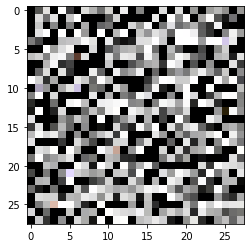

In [0]:
plt.imshow((X[1].numpy().astype(int)))

In [0]:
occlude_start_row = 14
num_generated_images = 10
samples = np.copy(x_test[0:num_generated_images, :, :, :])
samples[:, occlude_start_row:, :, :] = 0

for i in range(occlude_start_row, height):
    for j in range(width):
        logits = pixelcnn(A, training=False)
        X = sample_from_discretized_mix_logistic(logits, nr_logistic_mix)
        samples[:, i, j, 0] = X[:,i, j, 0]

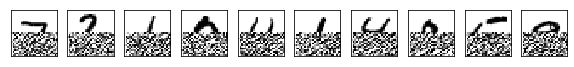

In [0]:

fig = plt.figure(figsize=(10, 10))
for i in range(10):
    ax = fig.add_subplot(10, 10, i+1)
    ax.matshow(samples[i, :, :, 0], cmap=matplotlib.cm.binary)
    plt.xticks(np.array([]))
    plt.yticks(np.array([]))
plt.show()
